# Greyskin87 - SQL project

This is a project made as part of the DataQuest path for Data Analysis and Data Science.

This project will be focused on querying a Sqlite3 database containing data needed to manage a music shop (employees, consumers, invoices, albums, tracks, etc.)


In [1]:
# Import relevant modules
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Define a function that takes a SQL query as an argument and return a pandas Dataframe
# This way the db is lock only when I'm actually querying it
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [3]:
# Define a function that takes a SQL command as an argument and executes it
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# Define a function that returns a list of all tables and views in the database
def show_tables():
    q= ('''
             SELECT
                 name,
                 type
             FROM sqlite_master
             WHERE type in ("table","view")
    ''')
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 1st task: decide music to buy for the store

I'm presented with this business problem: I have to choose three new artist within a list of four. I know the name of the artists and the genre of their music, and I know i want to target the USA market.

In [6]:
#Write a query that returns each genre, with the number of tracks sold in aboslute numbers and in percentages
q = '''
WITH
track_sold AS
(
    SELECT 
        t.track_id,
        t.name track_title,
        COUNT(t.track_id) track_sold,
        g.genre_id
    FROM track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    GROUP BY 1
    ORDER BY 1 ASC
),

track_sold_by_genre AS
(
    SELECT
        g.name genre,
        SUM(ts.track_sold) track_sold
    FROM track_sold ts
    INNER JOIN genre g ON g.genre_id = ts.genre_id
    GROUP BY 1
    ORDER BY 1 ASC
)

SELECT 
    tsg.genre,
    tsg.track_sold,
    (tsg.track_sold / 
    (SELECT
        CAST(SUM(ts.track_sold) AS float) total
    FROM track_sold ts)) track_sold_perc
FROM track_sold_by_genre tsg
ORDER BY 2 DESC


'''
    
genre_sales_USA = run_query(q)    

In [7]:
genre_sales_USA

,genre,track_sold,track_sold_perc
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [8]:
# Create a plot to show the data
genre_sales_USA_plot = genre_sales_USA.sort_values(by = 'track_sold').set_index('genre',drop=True)

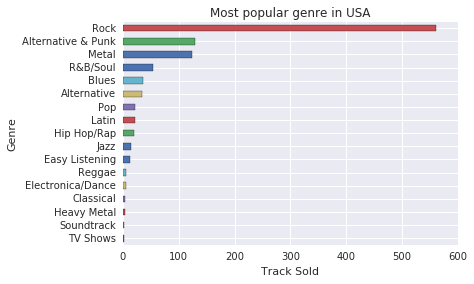

In [9]:
ax = genre_sales_USA_plot.plot.barh(y='track_sold', title='Most popular genre in USA', legend=None)
ax.set_xlabel('Track Sold')
ax.set_ylabel('Genre')

This are the Artists I can choose from:

<table>
<thead>
    <th>Artist Name</th>
    <th>Genre</th>
    <th>Position</th>
</thead>
<tbody>
    <tr>
        <td>Regal</td>
        <td>Hip-Hop</td>
        <td>9</td>
    </tr>
    <tr>
        <td>Red Tone</td>
        <td>Punk</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Meteor and the Girls</td>
        <td>Pop</td>
        <td>7</td>
    </tr>
    <tr>
        <td>Slim Jim Bites</td>
        <td>Blues</td>
        <td>4</td>
    </tr>
</tbody>
</table>

From this analysis I can then assume that I do not want to buy the Album by Regal

## 2nd task: evaluate the Sales Support Agent performance

My task is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others


In [10]:
q = '''
WITH
customer_expenses AS
(
    SELECT
        c.customer_id,
        c.first_name || " " || c.last_name customer_name,
        c.country customer_country,
        c.support_rep_id support_id,
        SUM(i.total) customer_expenses
    FROM customer c 
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    ORDER BY 1
),

managers AS
(
    SELECT
        e.employee_id,
        e.first_name || " " || e.last_name employee_name,
        e2.first_name || " " || e2.last_name manager_name,
        e2.title manager_title
    from employee e
    INNER JOIN employee e2 ON e2.employee_id = e.reports_to        
)

SELECT
    e.employee_id,
    e.first_name || " " || e.last_name employee_name,
    e.country employee_country,
    e.hire_date,
    e.title,
    m.manager_name,
    m.manager_title,
    SUM(ce.customer_expenses) employee_earnings

FROM employee e
INNER JOIN customer_expenses ce ON ce.support_id = e.employee_id
INNER JOIN managers m ON m.employee_id = e.employee_id
GROUP BY 1
ORDER BY employee_earnings DESC

'''

In [11]:
total_earnings = run_query(q)
total_earnings

,employee_id,employee_name,employee_country,hire_date,title,manager_name,manager_title,employee_earnings
0,3,Jane Peacock,Canada,2017-04-01 00:00:00,Sales Support Agent,Nancy Edwards,Sales Manager,1731.51
1,4,Margaret Park,Canada,2017-05-03 00:00:00,Sales Support Agent,Nancy Edwards,Sales Manager,1584.00
2,5,Steve Johnson,Canada,2017-10-17 00:00:00,Sales Support Agent,Nancy Edwards,Sales Manager,1393.92


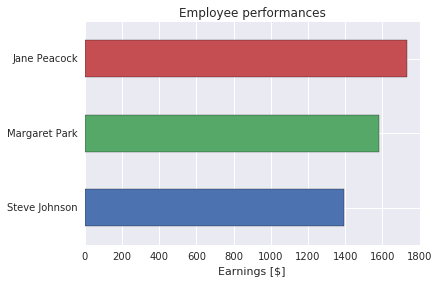

In [12]:
# Plotting the result
ax = total_earnings.sort_values(by='employee_earnings').set_index('employee_name').plot.barh(y='employee_earnings',legend=None)
ax.set_xlabel('Earnings [$]')
ax.set_ylabel('')
ax.set_title('Employee performances')

From this view it seems that more experienced employee (the one hired before) performs better than the ones with less experienced.

All employees are from the same country (Canada) and report to the same manager (Nancy Edwards) so it appears to me that hire date is the only relevant parameter in this evaluation apart from the employee ability.

## 3rd task: analyze sales data for customers from each different country

For each country (in the customer table) I'm instructed to calculate:
+ Total number of customers
+ Total value of sales
+ Average value of sales per customer
+ Average order value

Specific instructions are that countries with only one customer has to be grouped under the "Other" category and that this group should always be at the bottom of the results.

In [13]:
run_command('DROP VIEW country_statistics')

c = '''
    CREATE VIEW country_statistics AS
    
    WITH 
    country_or_other AS
    (
    SELECT 
        CASE 
            WHEN (
                SELECT
                    COUNT(*)
                FROM customer
                WHERE country = c.country
            ) == 1 THEN 'Other'
            ELSE c.country
        END as country,
        c.*
    FROM customer c
    ),
    
    country_aggregates AS
    (
        SELECT 
            c.country,
            COUNT(distinct c.customer_id) customers_number,
            SUM(i.total) total_sales,
            COUNT(distinct i.invoice_id) orders_number
        FROM 
        country_or_other c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1
    )
        
    SELECT 
        ca.country,
        ca.customers_number,
        ca.total_sales,
        ca.total_sales / CAST(ca.customers_number AS float) sales_avg,
        ca.total_sales / CAST(ca.orders_number AS float) orders_avg
    FROM country_aggregates ca
'''
run_command(c)

In [14]:
q = '''
SELECT 
    country,
    customers_number,
    total_sales,
    orders_avg,
    sales_avg customer_avg
FROM (
    SELECT 
    cs.*,
    CASE
        WHEN(cs.country) = 'Other' THEN 1
        ELSE 0
    END as sort
    FROM country_statistics as cs
    ORDER BY sort ASC, cs.total_sales DESC 
) 
'''

results = run_query(q)
results

,country,customers_number,total_sales,orders_avg,customer_avg
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## 4th task: create a series of visualization to communicate the findings and make recommendations on which country may have potential for growth

I'll begin with some basic plot: pie chart and bar chart for the number of customers and the total sales

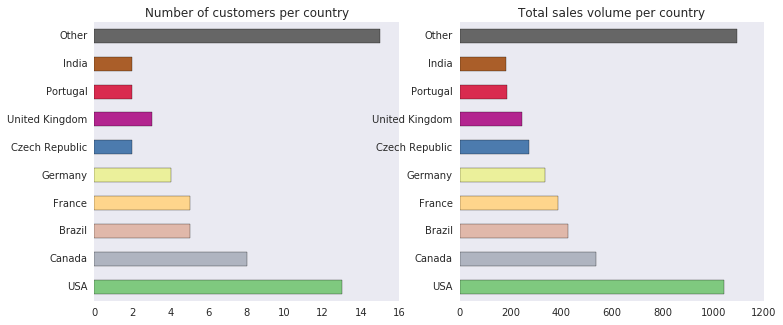

In [15]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, results.shape[0])]

fig, axes = plt.subplots(1,2, figsize=(12,5))
ax1, ax2 = axes.flatten()

ax1 = results.set_index('country').plot.barh(ax=ax1,y='customers_number',title='Number of customers per country',legend=None, color=colors)
ax1.set_ylabel('')
sns.set_style('white')
ax1.grid(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = results.set_index('country').plot.barh(ax=ax2,y='total_sales',title='Total sales volume per country', legend=None, color=colors)
ax2.set_ylabel('')
sns.set_style('white')
ax2.grid(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

(-1.0055349452269702,
 1.0004230701289913,
 -1.00311101434914,
 1.0000000864216336)

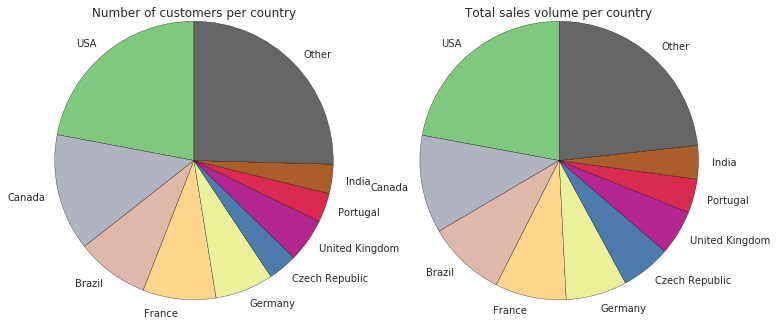

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax1, ax2 = axes.flatten()


ax1 = results.set_index('country').plot.pie(ax=ax1,y='customers_number',title='Number of customers per country',legend=None,startangle=90, colormap=plt.cm.Accent)
ax1.set_ylabel('')
sns.set_style('white')
ax1.grid(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2 = results.set_index('country').plot.pie(ax=ax2,y='total_sales',title='Total sales volume per country',legend=None,startangle=90, colormap=plt.cm.Accent)
ax2.set_ylabel('')
sns.set_style('white')
ax2.grid(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



There is a clear correlation between the number of customers per country and the total volume per country. 
To better see this, let's look at the country breakdown as percenteage


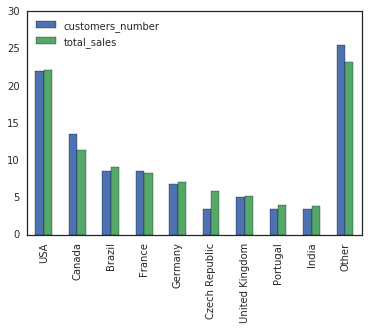

In [17]:
cols = ['country','customers_number','total_sales']
num_cols = ['customers_number','total_sales']
df_plot = results.loc[:,cols]
for c in num_cols:
    df_plot.loc[:,c] /= df_plot.loc[:,c].sum() / 100

ax = df_plot.set_index('country').plot.bar()
ax.set_xlabel('')

Countries with potential for growth are the ones with a low number of customers but high sales. I want to look for countries with an average order higher than the mean average order

Probably I'll have to choose from Czech Republic, United Kingdom, Portugal, India"

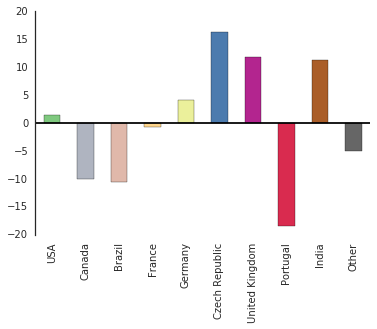

In [18]:
cols = ['country','orders_avg']

df_plot = results[cols].copy().set_index('country')

df_plot = (df_plot /df_plot.mean() - 1) * 100

ax1 = df_plot.plot.bar(y='orders_avg', color=colors, legend=None)
ax1.set_xlabel('')
sns.set_style('white')
ax1.grid(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axhline(0,color='k')




It's now clear that Czech Republic, United Kindgom and India are good candidates for marketing campaigns, while portugal is not.

## 5th task: categorize each invoice as either an album purchase or not

I have to calculate the following statistics:
+ Number of Invoices
+ Percentage of invoices

In [19]:
# Fisrt Query: select the first track of each invoice

#first_track
q = ('''   
SELECT
    i.invoice_id,
    t.track_id,
    a.album_id
FROM
    invoice i 
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
GROUP BY 1    
''') 

run_query(q)

,invoice_id,track_id,album_id
0,1,1173,91
1,2,2651,215
2,3,2646,214
3,4,2514,203
4,5,2002,163
5,6,30,5
6,7,42,6
7,8,1560,125
8,9,196,20
9,10,3290,257


In [20]:
# Check all the tracks for the invoice

#invoice_tracks
q = ('''
SELECT
    i.invoice_id,
    t.track_id
FROM
    invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
WHERE
    i.invoice_id = 1
''')

run_query(q)

,invoice_id,track_id
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162
5,1,1163
6,1,1164
7,1,1165
8,1,1166
9,1,1167


In [21]:
# From the table before, I have to extract the track list of the album

#album_tracks
q = ('''
WITH first_tracks AS
(
SELECT
    i.invoice_id,
    t.track_id,
    a.album_id
FROM
    invoice i 
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
GROUP BY 1  
)

SELECT
    a.album_id,
    t.track_id
FROM first_tracks ft
INNER JOIN track t
INNER JOIN album a ON a.album_id = t.album_id
WHERE a.album_id = ft.album_id and ft.invoice_id = 1
''')

run_query(q)

,album_id,track_id
0,91,1158
1,91,1159
2,91,1160
3,91,1161
4,91,1162
5,91,1163
6,91,1164
7,91,1165
8,91,1166
9,91,1167


In [40]:
# For each invoice now I can check if the two tables are equal

q=('''
WITH first_tracks AS
(
SELECT
    i.invoice_id,
    t.track_id,
    a.album_id
FROM
    invoice i 
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
GROUP BY 1  
),

full_album AS
(
SELECT
    ft.invoice_id,
    CASE 
        WHEN(
        -- tracks from the invoice are the same as tracks from the album
        
            (   --Select invoice tracks
            SELECT
                --i.invoice_id,
                t.track_id
            FROM
                invoice i
                INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                INNER JOIN track t ON t.track_id = il.track_id
            WHERE
                i.invoice_id = ft.invoice_id
                
            EXCEPT
            
            --Select album tracks
            --Select a track for which the album is the same of the one of the first_track
            SELECT 
                t.track_id
            FROM track t
            WHERE t.album_id = (
                SELECT
                    t2.album_id
                FROM track t2 
                WHERE t2.track_id = ft.track_id
            )
            ) IS NULL
        
        AND
        
            (
            --Select album tracks
            --Select a track for which the album is the same of the one of the first_track
            SELECT 
                t.track_id
            FROM track t
            WHERE t.album_id = (
                SELECT
                    t2.album_id
                FROM track t2 
                WHERE t2.track_id = ft.track_id
            )
                
            EXCEPT
                
            --Select invoice tracks
            SELECT
                --i.invoice_id,
                t.track_id
            FROM
                invoice i
                INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                INNER JOIN track t ON t.track_id = il.track_id
            WHERE
                i.invoice_id = ft.invoice_id             
            ) IS NULL
        ) 
        THEN('yes') 
        ELSE('no')
    END AS 'full_album'

FROM first_tracks ft
)

SELECT 
    full_album,
    COUNT(invoice_id) invoices,
    CAST(COUNT(invoice_id) as float) / (SELECT COUNT(*) FROM invoice) percent
FROM full_album fa
GROUP BY 1



''')

run_query(q)

,full_album,invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases accounts for 18.6% of the total sales. Therefore Chinook store should continue to buy full albums: doing the opposite could lead to a loss of revenues of about 20%